# ESRGAN on WorldView-02 satellite imagery

https://arxiv.org/pdf/1809.00219.pdf

https://paperswithcode.com/paper/esrgan-enhanced-super-resolution-generative

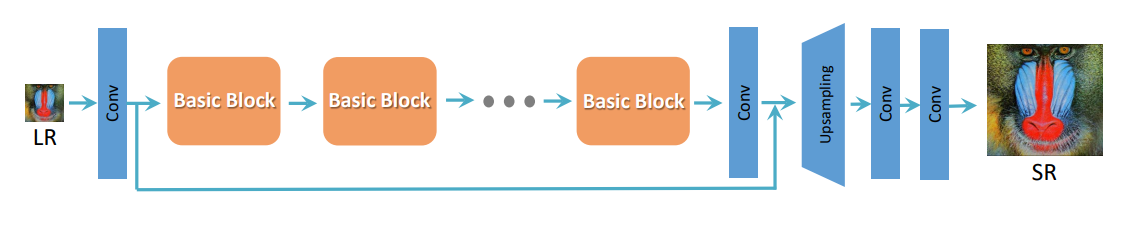

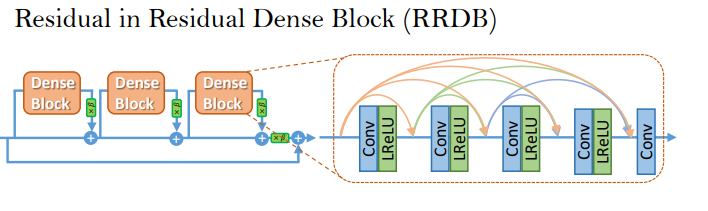

ESRGAN Won the PIRM 2018 SR challenge (for lowest perceptual index in region 3). This is an adaptation of ESRGAN to the multispectral (LR) to panchromatic (HR) mapping problem.

Key points about ESRGAN
- Improves on SRGAN from 2016 in several ways
 - Using RRDB (Residual in Residual Dense Blocks) design allowing for deeper models without vanishing gradient problem
 - Removing Batch Normalization layers, empirically shown to reduce artefacts
 - Relativistic GAN loss used for the discriminator
  - Predicts probability that a real image is relatively more realistic than a fake one and vice versa
  - Adversarial loss function thus include both real and fake/generated image (SRGAN only include generated)
 - Introduces interpolation between pretrained PSNR model and GAN model to tune trade-off between artefacts/smoothness
- Generator loss function components
 - Pixel loss in the form om L1 (Absolute Mean Error loss)
 - Adversarial loss from the discriminator
 - Content loss / Perceptual loss
  - Feature extraction from layer 54 of a VGG-19 model trained on ImageNet (before activation)
  
This implementation/adaptation
- Approx 17 million parameters
 - 8 bands/channels in (96x96)
 - 1 out (the panchromatic band) (384x384)
 - 4x upsampling
 - Satellite tiles sampled from satellite images
 - Georeference information preserved

# Imports and setup

In [ ]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import pathlib
import rasterio
import rasterio.plot
import geopandas
import pickle
import functools
import datetime

#from skvideo.measure import niqe, brisque_features

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, LeakyReLU, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

# matlab must be imported after tensorflow to avoid issues with cuDNN
import matlab.engine

from modules.image_utils import *

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Check GPUs:",
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Prevent TensorFlow from allocating all memory of all GPUs:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
tf.sysconfig.get_build_info()

In [ ]:
##################### CONFIG PARAMETERS ##########################
############## THIS WILL BE REFACTORED INTO A JSON FILE ##########

######### HIGH LEVEL SETUP #######
SETUP = {'train': 'WV02', 'val': 'WV02', 'test': 'WV02'}
LARGE = False
#SETUP = {'train': 'WV02', 'val': 'GE01', 'test': 'GE01'}
print('Setup:', SETUP)
##################################

######### PATHS ##################
# Path to location where individual satellite images are located
DATA_PATH = 'data/toulon-laspezia'

# Paths to the tiled imagery
if LARGE:
    DATA_PATH_TILES = 'data/toulon-laspezia-tiles-large'
else:
    #DATA_PATH_TILES = 'data/toulon-laspezia-tiles'
    DATA_PATH_TILES = 'data/toulon-laspezia-tiles-noseaclouds'
    
DATA_PATH_TILES_TRAIN = str(DATA_PATH_TILES + '/' + SETUP['train'] + '/train')
DATA_PATH_TILES_VAL = str(DATA_PATH_TILES + '/' + SETUP['val'] + '/val')
DATA_PATH_TILES_TEST = str(DATA_PATH_TILES + '/' + SETUP['test'] + '/test')
print('Data path:', DATA_PATH_TILES)

RESULTS_PATH = 'results'
if LARGE:
    RESULTS_VAL_PATH = str(RESULTS_PATH + '/val-large')
else:
    RESULTS_VAL_PATH = str(RESULTS_PATH + '/val')

MATLAB_MA_PATH = 'modules/sr-metric'
####################################

########## METADATA DATAFRAME ######
# Loading the metadata geopandas df produced when generating tiles to disk
def load_and_join_metas(setup):
    s = set(setup.values())
    metas = []
    for sensor in s:
        path = str(DATA_PATH_TILES + '/' + sensor + '/metadata_tile_allocation.pickle')
        with open(path, 'rb') as file:
            metas.append(pickle.load(file))
    meta = pd.concat(metas)
    for partit in setup:
        meta.drop(meta[(meta['train_val_test'] == partit) & 
                       (meta['sensorVehicle'] != setup[partit])].index, 
                  inplace = True)
    return meta
meta = load_and_join_metas(SETUP)
####################################

########## DATA DERIVED FROM METADATA DATAFRAME ######
#### Will probably not be included in json file ######
N_IMAGES = len(meta.index)
N_IMAGES_TRAIN = meta['train_val_test'].value_counts()['train']
N_IMAGES_VAL = meta['train_val_test'].value_counts()['val']
N_IMAGES_TEST = meta['train_val_test'].value_counts()['test']
print('Number of satellite images - train:', N_IMAGES_TRAIN, 
      ', val:', N_IMAGES_VAL, ', test:', N_IMAGES_TEST)

N_TILES_TRAIN = meta.loc[meta['train_val_test'] == 'train', 'n_tiles'].sum()
N_TILES_VAL = meta.loc[meta['train_val_test'] == 'val', 'n_tiles'].sum()
N_TILES_TEST = meta.loc[meta['train_val_test'] == 'test', 'n_tiles'].sum()
print('Number of satellite image tiles - train:', N_TILES_TRAIN, 
      ', val:', N_TILES_VAL, ', test:', N_TILES_TEST)

########## IMAGE SIZES, CHANNELS etc. #####################
if LARGE:
    PAN_WIDTH, PAN_HEIGHT = (1024, 1024)
    #PAN_WIDTH, PAN_HEIGHT = (384, 384)
else:
    PAN_WIDTH, PAN_HEIGHT = (128, 128)

SR_FACTOR = 4
MS_WIDTH, MS_HEIGHT = (int(PAN_WIDTH/SR_FACTOR), int(PAN_HEIGHT/SR_FACTOR))
print('PAN (HR) width x height:', PAN_WIDTH, 'x', PAN_HEIGHT)
print('MS (LR) width x height:', MS_WIDTH, 'x', MS_HEIGHT) 

WV02_BANDS = list(meta.loc[meta['sensorVehicle'] == 'WV02', ['ms_band0', 'ms_band1', 
                                                             'ms_band2', 'ms_band3', 
                                                             'ms_band4', 'ms_band5',
                                                             'ms_band6', 'ms_band7']].iloc[0])
#GE01_BANDS = list(meta.loc[meta['sensorVehicle'] == 'GE01', ['ms_band0', 'ms_band1', 
#                                                             'ms_band2', 'ms_band3']].iloc[0])
WV02_GE01_IMITATE_BANDS = [1, 2, 4, 6] # The WV02 band indices that correspond to GE01 bands
if 'GE01' in SETUP.values():
    print('GeoEye-01 bands:', GE01_BANDS)
print('WorldView-02 bands:', WV02_BANDS)
if 'GE01' in SETUP.values():
    print('WorldView-02 bands equal to GeoEye-01 profile:', 
          [WV02_BANDS[band] for band in WV02_GE01_IMITATE_BANDS])

PAN_BANDS = 1
if 'GE01' in SETUP.values():
    MS_BANDS = len(GE01_BANDS)
else:
    MS_BANDS = len(WV02_BANDS)
print('PAN (HR) bands (channels):', PAN_BANDS)
print('MS (LR) bands (channels):', MS_BANDS)
##########################################################

############ NEURAL NET CONFIGS ##########################
if LARGE:
    BATCH_SIZE = 2
else:
    BATCH_SIZE = 16
print('Batch size:', BATCH_SIZE)

N_BLOCKS = 16
#N_BLOCKS = 23
N_FILTERS = 64
#N_FILTERS = 32
##########################################################
    
########### SHUFFLE BUFFER SIZES #########################
SHUFFLE_BUFFER_TRAIN, SHUFFLE_BUFFER_VAL, SHUFFLE_BUFFER_TEST = N_TILES_TRAIN, N_TILES_VAL, N_TILES_TEST
#SHUFFLE_BUFFER_TRAIN, SHUFFLE_BUFFER_VAL, SHUFFLE_BUFFER_TEST = N_TILES_TRAIN/2, N_TILES_VAL/2, N_TILES_TEST/2
#SHUFFLE_BUFFER_TRAIN, SHUFFLE_BUFFER_VAL, SHUFFLE_BUFFER_TEST = 1000, 1000, 1000

print('Shuffle buffers - train:', SHUFFLE_BUFFER_TRAIN, ', val:', SHUFFLE_BUFFER_VAL, ', test:', SHUFFLE_BUFFER_TEST)
##########################################################

########### OPTIMIZER ####################################
PRETRAIN_LR_STEPS = [50000, 100000, 150000]
PRETRAIN_LR_VALUES = [0.00002, 0.00001, 0.000005, 0.0000025]

# Tensorflow tile generator from disk

Using `tf.data` API to construct a `Dataset` generator reading and preprocessing tiles from disk.

Best practices from https://www.tensorflow.org/guide/data, including multithreading, prefetching, shuffling, batching and caching.

`rasterio` is used to read geotiffs. the `decode_geotiff()` function is run inside a `tf.py_function()` wrapper ensuring that this function is also run in the computational graph.

In [ ]:
#TODO: Preserve filename through the process
#TODO: Preserve georeference information through the process

def wv02_imitate_ge01(img):
    img = np.take(img, WV02_GE01_IMITATE_BANDS, -1)
    return img

def decode_geotiff(image_path):
    image_path = pathlib.Path(image_path.numpy().decode())
    with rasterio.open(image_path) as src:
        img = src.read()
    img = rasterio.plot.reshape_as_image(img) # from channels first to channels last
    
    # Imitate GE01 sensor by dropping WV02 bands?
    if img.shape[-1] == len(WV02_BANDS) and MS_BANDS == 4: # Should be 8 and 4
        img = wv02_imitate_ge01(img)
    return img

def preprocess_images(img, ms_or_pan):
    if ms_or_pan == 'ms':
        h, w = MS_HEIGHT, MS_WIDTH
    elif ms_or_pan == 'pan':
        h, w = PAN_HEIGHT, PAN_WIDTH
        
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.reshape(img, [h, w, -1]) # To avoid issue with extra dimension
    return img

def upsample_images(ms_img, pan_img):
    ms_img = tf.ensure_shape(ms_img, [MS_HEIGHT, MS_WIDTH, MS_BANDS])
    ms_img = tf.image.resize(ms_img, [PAN_HEIGHT, PAN_WIDTH])
    return ms_img, pan_img

def process_path(ms_tile_path):
    img_string_UID = tf.strings.split(ms_tile_path, os.sep)[-3]
    tile_UID = tf.strings.split(tf.strings.split(ms_tile_path, os.sep)[-1], '.')[0]
    
    ms_img = tf.py_function(decode_geotiff, [ms_tile_path], [tf.int16], name = 'decode_geotiff_ms')
    pan_tile_path = tf.strings.regex_replace(ms_tile_path, '\\\\ms\\\\', '\\\\pan\\\\')
    pan_img = tf.py_function(decode_geotiff, [pan_tile_path], [tf.int16], name = 'decode_geotiff_pan')
    
    ms_img = preprocess_images(ms_img, 'ms')
    pan_img = preprocess_images(pan_img, 'pan')
    
    return ms_img, pan_img

# https://www.tensorflow.org/tutorials/load_data/images
def prepare_for_training(ds, batch_size, cache_memory=True, cache_file=None, shuffle_buffer_size=100):
    # File caching
    if isinstance(cache_file, str):
        ds = ds.cache(cache_file)
    # Memory caching (both can be combined)
    if cache_memory:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(batch_size)
    
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
def dataset_from_tif_tiles(tiles_path, batch_size, upsampling = False, 
                           cache_memory=True, cache_file=None, shuffle_buffer_size = 1000):
    
    ds = tf.data.Dataset.list_files(str(pathlib.Path(tiles_path)/'*/ms*.tif'))
    ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
    
    
    # upsampling through bicubic convolution before SR is required for SRCNN
    if upsampling:
        ds = ds.map(upsample_images, num_parallel_calls=AUTOTUNE)

    ds = prepare_for_training(ds, batch_size, cache_memory, cache_file, shuffle_buffer_size)
    return ds

ds_train = dataset_from_tif_tiles(DATA_PATH_TILES_TRAIN, BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_TRAIN,
                                  cache_memory=True, cache_file=str(DATA_PATH_TILES+'/ds_train_cache'))
ds_val = dataset_from_tif_tiles(DATA_PATH_TILES_VAL, BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_VAL, 
                                cache_memory=True, cache_file=str(DATA_PATH_TILES+'/ds_val_cache'))
ds_test = dataset_from_tif_tiles(DATA_PATH_TILES_TEST, BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_TEST,
                                 cache_memory=True, cache_file=str(DATA_PATH_TILES+'/ds_train_cache'))

In [ ]:
#next(iter(ds_train))
#batch = next(iter(ds_train))

# Bicubic model

Bicubic upsampling as a fixed (untrainable) tf.keras model. Used for comparison purposes.

In [ ]:
def psnr(hr, sr): #hr == y_true, sr == y_pred
    return tf.image.psnr(hr, sr, max_val=1.0)

def ssim(hr, sr): #hr == y_true, sr == y_pred
    return tf.image.ssim(hr, sr, max_val=1.0)

def bicubic_model(size, upsample_factor, channels_in, channels_out):
    inputs = Input([size, size, channels_in], name='input_image')
    x = Lambda(lambda x:
               tf.expand_dims(tf.math.reduce_mean(x, axis = -1), axis = -1))(inputs)
    x = Lambda(lambda x: 
               tf.image.resize(x, [size*upsample_factor, size*upsample_factor], 
               method=tf.image.ResizeMethod.BICUBIC, preserve_aspect_ratio=False,
               antialias=False, name=None))(x)
    return Model(inputs, x, name='bicubic_upsample_model')

bicubic = bicubic_model(MS_HEIGHT, SR_FACTOR, MS_BANDS, PAN_BANDS)
bicubic.compile(loss='mean_absolute_error', metrics = [psnr, ssim])
bicubic.summary()

# Build the Residual-in-Residual Dense Block (RRDB) model

Reference https://github.com/peteryuX/esrgan-tf2 

TODO: Proper citation

In [ ]:
def _regularizer(weights_decay=5e-4):
    return tf.keras.regularizers.l2(weights_decay)

def _kernel_init(scale=1.0, seed=None):
    """He normal initializer with scale."""
    scale = 2. * scale
    return tf.keras.initializers.VarianceScaling(
        scale=scale, mode='fan_in', distribution="truncated_normal", seed=seed)

class BatchNormalization(tf.keras.layers.BatchNormalization):
    """Make trainable=False freeze BN for real (the og version is sad).
       ref: https://github.com/zzh8829/yolov3-tf2
    """
    def __init__(self, axis=-1, momentum=0.9, epsilon=1e-5, center=True,
                 scale=True, name=None, **kwargs):
        super(BatchNormalization, self).__init__(
            axis=axis, momentum=momentum, epsilon=epsilon, center=center,
            scale=scale, name=name, **kwargs)

    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

class ResDenseBlock_5C(tf.keras.layers.Layer):
    """Residual Dense Block"""
    def __init__(self, nf=64, gc=32, res_beta=0.2, wd=0., name='RDB5C',
                 **kwargs):
        super(ResDenseBlock_5C, self).__init__(name=name, **kwargs)
        # gc: growth channel, i.e. intermediate channels
        self.res_beta = res_beta
        lrelu_f = functools.partial(LeakyReLU, alpha=0.2)
        _Conv2DLayer = functools.partial(
            Conv2D, kernel_size=3, padding='same',
            kernel_initializer=_kernel_init(0.1), bias_initializer='zeros',
            kernel_regularizer=_regularizer(wd))
        self.conv1 = _Conv2DLayer(filters=gc, activation=lrelu_f())
        self.conv2 = _Conv2DLayer(filters=gc, activation=lrelu_f())
        self.conv3 = _Conv2DLayer(filters=gc, activation=lrelu_f())
        self.conv4 = _Conv2DLayer(filters=gc, activation=lrelu_f())
        self.conv5 = _Conv2DLayer(filters=nf, activation=lrelu_f())

    def call(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(tf.concat([x, x1], 3))
        x3 = self.conv3(tf.concat([x, x1, x2], 3))
        x4 = self.conv4(tf.concat([x, x1, x2, x3], 3))
        x5 = self.conv5(tf.concat([x, x1, x2, x3, x4], 3))
        return x5 * self.res_beta + x

class ResInResDenseBlock(tf.keras.layers.Layer):
    """Residual in Residual Dense Block"""
    def __init__(self, nf=64, gc=32, res_beta=0.2, wd=0., name='RRDB',
                 **kwargs):
        super(ResInResDenseBlock, self).__init__(name=name, **kwargs)
        self.res_beta = res_beta
        self.rdb_1 = ResDenseBlock_5C(nf, gc, res_beta=res_beta, wd=wd)
        self.rdb_2 = ResDenseBlock_5C(nf, gc, res_beta=res_beta, wd=wd)
        self.rdb_3 = ResDenseBlock_5C(nf, gc, res_beta=res_beta, wd=wd)

    def call(self, x):
        out = self.rdb_1(x)
        out = self.rdb_2(out)
        out = self.rdb_3(out)
        return out * self.res_beta + x


def RRDB_Model(size, channels_in, channels_out, nb=23, nf=64, gc=32, wd=0., name='RRDB_model'):
    """Residual-in-Residual Dense Block based Model """
    lrelu_f = functools.partial(LeakyReLU, alpha=0.2)
    rrdb_f = functools.partial(ResInResDenseBlock, nf=nf, gc=gc, wd=wd)
    conv_f = functools.partial(Conv2D, kernel_size=3, padding='same',
                               bias_initializer='zeros',
                               kernel_initializer=_kernel_init(),
                               kernel_regularizer=_regularizer(wd))
    rrdb_truck_f = tf.keras.Sequential(
        [rrdb_f(name="RRDB_{}".format(i)) for i in range(nb)],
        name='RRDB_trunk')

    # extraction
    x = inputs = Input([size, size, channels_in], name='input_image')
    fea = conv_f(filters=nf, name='conv_first')(x)
    fea_rrdb = rrdb_truck_f(fea)
    trunck = conv_f(filters=nf, name='conv_trunk')(fea_rrdb)
    fea = fea + trunck

    # upsampling
    size_fea_h = tf.shape(fea)[1] if size is None else size
    size_fea_w = tf.shape(fea)[2] if size is None else size
    fea_resize = tf.image.resize(fea, [size_fea_h * 2, size_fea_w * 2],
                                 method='nearest', name='upsample_nn_1')
    fea = conv_f(filters=nf, activation=lrelu_f(), name='upconv_1')(fea_resize)
    fea_resize = tf.image.resize(fea, [size_fea_h * 4, size_fea_w * 4],
                                 method='nearest', name='upsample_nn_2')
    fea = conv_f(filters=nf, activation=lrelu_f(), name='upconv_2')(fea_resize)
    fea = conv_f(filters=nf, activation=lrelu_f(), name='conv_hr')(fea)
    out = conv_f(filters=channels_out, name='conv_last')(fea)

    return Model(inputs, out, name=name)

def build_generator(optimizer, loss = 'mean_absolute_error', 
                     n_channels_in = MS_BANDS, n_channels_out = PAN_BANDS,
                     height_width = None, # None will make network image size agnostic 
                     n_filters = N_FILTERS, n_blocks = N_BLOCKS, metrics = [psnr, ssim]):
    
    rrdb = RRDB_Model(height_width, n_channels_in, n_channels_out, nb=n_blocks, nf=n_filters)
    rrdb.compile(optimizer=optimizer, loss=loss, metrics = metrics)
    return rrdb

pretrain_lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=PRETRAIN_LR_STEPS, values=PRETRAIN_LR_VALUES)
pretrain_model =  build_generator(optimizer = Adam(learning_rate=pretrain_lr_schedule, beta_1=0.9, beta_2=0.999))
#pretrain_model.summary()

## Callbacks and Tensorboard logging

In [ ]:
pretrain_model_name = str('esrgan-psnr-train-' + SETUP['train'] + '-val-' + SETUP['val'])
log_dir = pathlib.Path('logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
    histogram_freq=10, write_graph=False, write_images=False,
    update_freq='epoch', profile_batch=2, embeddings_freq=0,
    embeddings_metadata=None)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = str('models/' + pretrain_model_name + '-{epoch:02d}-{val_loss:.6f}.h5'), 
    monitor = "val_loss",
    save_best_only = False,
    save_weights_only = True,
    )

#### Logging images in Tensorboard ####
file_writer = tf.summary.create_file_writer(str(log_dir))

# Sample ONE batch that will be used for logging of images throughout iterations
tb_batch_train = next(iter(ds_train))
tb_batch_val = next(iter(ds_val))
model = pretrain_model # enable log_images() to work on both pretrain and gan models

def log_train_images(epoch, logs):
    batch = tb_batch_train
    lr = stretch_batch(ms_to_rgb_batch(batch[0]))
    hr = stretch_batch(batch[1])
    sr = model.predict(batch)
    sr = stretch_batch(sr)

    with file_writer.as_default():
        tf.summary.image("Train - LR (MS)", lr, step=epoch, max_outputs=BATCH_SIZE)
        tf.summary.image("Train - SR", sr, step=epoch, max_outputs=BATCH_SIZE)
        tf.summary.image("Train - HR (PAN)", hr, step=epoch, max_outputs=BATCH_SIZE)
        
def log_val_images(epoch, logs):
    batch = tb_batch_val
    lr = stretch_batch(ms_to_rgb_batch(batch[0]))
    hr = stretch_batch(batch[1])
    sr = model.predict(batch)
    sr = stretch_batch(sr)

    with file_writer.as_default():
        tf.summary.image("Val - LR (MS)", lr, step=epoch, max_outputs=BATCH_SIZE)
        tf.summary.image("Val - SR", sr, step=epoch, max_outputs=BATCH_SIZE)
        tf.summary.image("Val - HR (PAN)", hr, step=epoch, max_outputs=BATCH_SIZE)

img_train_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_train_images)
img_val_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_val_images)

# Pretraining the model with PSNR loss

This is done in the ESRGAN paper and the rationale behind is that you want a reasonable starting point for your GAN training later.

In [ ]:
#pretrain_model.load_weights("models/esrgan-psnr-train-WV02-val-WV02-98-0.001750.h5")
EPOCHS = 200

history = pretrain_model.fit(ds_train, 
                             epochs = EPOCHS, 
                             validation_data = ds_val,
                             steps_per_epoch = 1000, 
                             validation_steps = 250, 
                             initial_epoch = 0, 
                             callbacks=[tensorboard_callback, checkpoint_callback, 
                                        img_train_callback, img_val_callback]
                             )
#pretrain_model.save_weights("models/esrgan-psnr-train-WV02-val-WV02-98-0.001750.h5")

# Visual inspection after pretraining

First we need some helper functions related to pansharpening and rgb coding of multispectral (ms) images.

## Plot functions

Some effort put into creating an adaptable comparison plot function.

In [ ]:
def plot_subplot(ax, img, title, gray = False, metrics = False):
    ax.set_title(title)
    if gray:
        ax.imshow(img, cmap = 'gray')
    else:
        ax.imshow(img)
        
    # TODO: Implement metrics in title
    #axs[0,1].set_title('MS Bicubic Upsampling ' + 
    #                   '\n PSNR: ' + 
    #                   str(psnr_np(bicubic[i], pan[i]).numpy()) + 
    #                   '\n SSIM: ' +
    #                   str(ssim_np(bicubic[i], pan[i]).numpy()))
    #axs[0,1].imshow(bicubic[i], cmap = cmap)
    return ax

def save_image_pairs(ms_img, pan_img, save_dir, filename, 
                     sr_pretrain_img = False, sr_gan_img = False, file_ext = 'png'):
    full_filename = str(filename + '.' + file_ext)
    sr_pretrain, sr_gan = False, False
    if not isinstance(sr_pretrain_img, bool):
        sr_pretrain = True
    if not isinstance(sr_gan_img, bool):
        sr_gan = True
    print(sr_pretrain, sr_gan)
    hr_dir = pathlib.Path(save_dir, 'hr')
    hr_dir.mkdir(exist_ok = True)
    lr_dir = pathlib.Path(save_dir, 'lr')
    lr_dir.mkdir(exist_ok = True)
    
    sr_pretrain_dir, sr_gan_dir = None, None
    if sr_pretrain:
        sr_pretrain_dir = pathlib.Path(save_dir, 'sr-pretrain')
        sr_pretrain_dir.mkdir(exist_ok = True)
    if sr_gan:
        sr_gan_dir = pathlib.Path(save_dir, 'sr-gan')
        sr_gan_dir.mkdir(exist_ok = True)
    
    if file_ext == 'png':
        tf.keras.preprocessing.image.save_img(lr_dir.joinpath(full_filename), ms_img, 
                                              data_format='channels_last', file_format='png', scale=True)
        tf.keras.preprocessing.image.save_img(hr_dir.joinpath(full_filename), 
                                              np.expand_dims(pan_img, -1), 
                                              data_format='channels_last', file_format='png', scale=True)
        if sr_pretrain:
            tf.keras.preprocessing.image.save_img(sr_pretrain_dir.joinpath(full_filename), 
                                                  np.expand_dims(sr_pretrain_img, -1),
                                                  data_format='channels_last', file_format='png', scale=True)
        if sr_gan:
            tf.keras.preprocessing.image.save_img(sr_gan_dir.joinpath(full_filename), sr_gan_img,
                                                  data_format='channels_last', file_format='png', scale=True)
    #TODO: file_ext = tif

    
def plot_comparison(ds, pretrain_model = False, gan_model = False, bicubic = True, 
                    rgb = True, pansharp = False, sensor = 'WV02', 
                    save_dir = False, save_raw = False, filename = False, raw_file_ext = 'png'):
    imgs, plot, gray, metrics = {}, {}, {}, {}
    batch = next(iter(ds))
    
    pretrain, gan = False, False
    if not isinstance(pretrain_model, bool):
        pretrain = True
    if not isinstance(gan_model, bool):
        gan = True
    
    imgs['ms'] = batch[0][0].numpy()
    imgs['ms_mean'] = tf.math.reduce_mean(imgs['ms'], axis = -1).numpy()
    plot['ms_mean'], gray['ms_mean'] = True, True
    
    if rgb:
        imgs['ms_rgb'] = ms_to_rgb(imgs['ms'], sensor = sensor)
        plot['ms_rgb'], gray['ms_rgb'] = True, False
    
    if bicubic:
        imgs['bicubic'] = tf.image.resize(imgs['ms'], 
                                          [imgs['ms'].shape[0]*SR_FACTOR, imgs['ms'].shape[1]*SR_FACTOR], 
                                          method=tf.image.ResizeMethod.BICUBIC).numpy()

        imgs['bicubic_mean'] = tf.math.reduce_mean(imgs['bicubic'], axis = -1).numpy()
        plot['bicubic_mean'], gray['bicubic_mean'] = True, True
        if rgb:
            imgs['bicubic_rgb'] = ms_to_rgb(imgs['bicubic'], sensor = sensor)
            plot['bicubic_rgb'], gray['bicubic_rgb'] = True, False
    
    if pretrain:
        imgs['sr_pretrain'] = pretrain_model.predict(batch)[0,:,:,0]
        plot['sr_pretrain'], gray['sr_pretrain'] = True, True
        
    if gan:
        imgs['sr_gan'] = gan_model.predict(batch)[0,:,:,0]
        plot['sr_gan'] = True
        gray['sr_gan'] = True
        
    imgs['pan'] = batch[1].numpy()[0,:,:,0]
    plot['pan'], gray['pan'] = True, True
    
    if pansharp:
        if pretrain:
            imgs['sr_pretrain_pansharp'] = pansharpen(imgs['ms'], imgs['sr_pretrain'], sensor = sensor, 
                                                      method = 'brovey', fourth_band = 'nir', 
                                                      w = [0.2]*5, stretch_output = True)
            plot['sr_pretrain_pansharp'], gray['sr_pretrain_pansharp'] = True, False

        if gan:
            imgs['sr_gan_pansharp'] = pansharpen(imgs['ms'], imgs['sr_gan'], sensor = sensor, 
                                                      method = 'brovey', fourth_band = 'nir', 
                                                      w = [0.2]*5, stretch_output = True)
            plot['sr_gan_pansharp'], gray['sr_gan_pansharp'] = True, False

        imgs['real_pansharp'] = pansharpen(imgs['ms'], imgs['pan'], sensor = sensor, 
                                                  method = 'brovey', fourth_band = 'nir', 
                                                  w = [0.2]*5, stretch_output = True)
        plot['real_pansharp'], gray['real_pansharp'] = True, False
    
    n_subplots = sum(plot.values())
    print('Plotting', n_subplots, 'subplots')
    for img_name in plot.keys():
        print(img_name, imgs[img_name].shape)
    n_cols = 3
    n_rows = math.ceil(n_subplots/n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, constrained_layout = True, 
                            figsize = (n_cols*10, n_rows*10))
    fig.suptitle('Satellite image tiles - Comparisons between multispectral, panchromatic and super-resolution images')
    fig.patch.set_facecolor('white')
    subplot_keys = list(plot.keys())
    k = 0
    for i in range(n_rows):
        for j in range(n_cols):
            img_name = subplot_keys[k]
            plot_subplot(axs[i,j], imgs[img_name], img_name, gray[img_name])
            k += 1
            if k >= len(subplot_keys):
                break
                
    if not isinstance(save_dir, bool) and not isinstance(filename, bool):
        fig_path = pathlib.Path(save_dir, str(filename + '.png'))
        fig.savefig(fig_path)
        if save_raw and raw_file_ext == 'png':
            # png implies saving an rgb version of the ms image
            if pretrain and not gan:
                save_image_pairs(imgs['ms_rgb'], imgs['pan'], save_dir, filename,
                                 sr_pretrain_img = imgs['sr_pretrain'], sr_gan_img = False,
                                 file_ext = raw_file_ext)
            elif not pretrain and gan:
                save_image_pairs(imgs['ms_rgb'], imgs['pan'], save_dir, filename,
                                 sr_pretrain_img = False, sr_gan_img = imgs['sr_gan'],
                                 file_ext = raw_file_ext)
            elif pretrain and gan:
                save_image_pairs(imgs['ms_rgb'], imgs['pan'], save_dir, filename,
                                 sr_pretrain_img = imgs['sr_pretrain'], sr_gan_img = imgs['sr_gan'],
                                 file_ext = raw_file_ext)
            else:
                save_image_pairs(imgs['ms_rgb'], imgs['pan'], save_dir, filename,
                                 sr_pretrain_img = False, sr_gan_img = False,
                                 file_ext = raw_file_ext)
        #TODO: raw_file_ext = tif
        

In [ ]:
#for i in range(50):
#    plot_comparison(ds_val, pretrain_model, gan_model = False, rgb = True, pansharp = False, sensor = SETUP['val'],
#                    save_dir = RESULTS_VAL_PATH, save_raw = True, filename = str('val' + str(i).zfill(3)), 
#                    raw_file_ext = 'png')

## Quantitative evalutation

Takes a couple of minutes.

# GAN training

Code currently heavily based on https://github.com/peteryuX/esrgan-tf2. Lacks a lot when it comes to Tensorboard monitoring.

Currently uses perceptual loss of an intermediate layer in a VGG19 model trained on ImageNet. This is probably suboptimal for the satellite imagery domain. Considering using a BigEarthNet VGG19 model instead http://bigearth.net/.

## Loss functions

In [ ]:
class DiscriminatorLoss(tf.keras.losses.Loss):
    def __init__(self, name='D_discr_loss'):
        super().__init__(name=name)
    
    # ragan loss
    def call(self, hr, sr): #hr == y_true, sr == y_pred
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        sigma = tf.sigmoid
        return 0.5 * (
            cross_entropy(tf.ones_like(hr), sigma(hr - tf.reduce_mean(sr))) +
            cross_entropy(tf.zeros_like(sr), sigma(sr - tf.reduce_mean(hr))))
    
class GeneratorLoss(tf.keras.losses.Loss):
    def __init__(self, name='G_generator_loss'):
        super().__init__(name=name)
    
    # ragan loss
    def call(self, hr, sr): #hr == y_true, sr == y_pred
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        sigma = tf.sigmoid
        return 0.5 * (
            cross_entropy(tf.ones_like(sr), sigma(sr - tf.reduce_mean(hr))) +
            cross_entropy(tf.zeros_like(hr), sigma(hr - tf.reduce_mean(sr))))
    
class PixelLoss(tf.keras.losses.Loss):
    def __init__(self, l1_l2 = 'l1', name='G_pixel_loss'):
        super().__init__(name=name)
        self.loss_func = self.l1_l2_loss(l1_l2)
    
    def l1_l2_loss(self, l1_l2):
        if l1_l2 == 'l1':
            loss_func = tf.keras.losses.MeanAbsoluteError()
        elif l1_l2 == 'l2':
            loss_func = tf.keras.losses.MeanSquaredError()
        else:
            raise NotImplementedError(
                'Loss type {} is not recognized.'.format(l1_l2))
        return loss_func
    
    def call(self, hr, sr): #hr == y_true, sr == y_pred
        return self.loss_func(hr, sr)

class PerceptualLoss(tf.keras.losses.Loss):
    def __init__(self, l1_l2='l1', output_layer=54, before_act=True, name='G_perceptual_loss'):
        super().__init__(name=name)
        self.loss_func = self.l1_l2_loss(l1_l2)
        self.feature_extractor = self.build_feature_extractor(output_layer, before_act)
    
    def l1_l2_loss(self, l1_l2):
        if l1_l2 == 'l1':
            loss_func = tf.keras.losses.MeanAbsoluteError()
        elif l1_l2 == 'l2':
            loss_func = tf.keras.losses.MeanSquaredError()
        else:
            raise NotImplementedError(
                'Loss type {} is not recognized.'.format(l1_l2))
        return loss_func

    def build_feature_extractor(self, output_layer, before_act):
        vgg = tf.keras.applications.VGG19(input_shape=(None, None, 3), weights='imagenet', 
                                          include_top=False)
        if output_layer == 22:  # Low level feature
            pick_layer = 5
        elif output_layer == 54:  # Hight level feature
            pick_layer = 20
        else:
            raise NotImplementedError(
                'VGG output layer {} is not recognized.'.format(output_layer))

        if before_act:
            vgg.layers[pick_layer].activation = None
        
        return tf.keras.Model(vgg.input, vgg.layers[pick_layer].output)  

    def call(self, hr, sr): #hr == y_true, sr == y_pred
        #print(sr.shape, hr.shape)
        sr_rgb = tf.image.grayscale_to_rgb(sr)
        hr_rgb = tf.image.grayscale_to_rgb(hr)
        #print(sr_rgb.shape, hr_rgb.shape)
        # the input scale range is [0, 1] (vgg is [0, 255]).
        # 12.75 is rescale factor for vgg featuremaps.
        preprocess_sr = tf.keras.applications.vgg19.preprocess_input(sr_rgb * 255.) / 12.75
        preprocess_hr = tf.keras.applications.vgg19.preprocess_input(hr_rgb * 255.) / 12.75
        #print(preprocess_sr.shape, preprocess_hr.shape)
        sr_features = self.feature_extractor(preprocess_sr)
        hr_features = self.feature_extractor(preprocess_hr)

        return self.loss_func(hr_features, sr_features)
    
class EsrganTotalGeneratorLoss(tf.keras.losses.Loss):
    def __init__(self, G_loss_pixel_f, G_loss_pixel_sc, 
                 G_loss_percep_f, G_loss_percep_sc, 
                 G_loss_generator_f, G_loss_generator_sc,
                 name='G_total_loss'):
        super().__init__(name=name)
        self.G_loss_pixel_f = G_loss_pixel_f
        self.G_loss_pixel_sc = G_loss_pixel_sc
        self.G_loss_percep_f = G_loss_percep_f
        self.G_loss_percep_sc = G_loss_percep_sc
        self.G_loss_generator_f = G_loss_generator_f
        self.G_loss_generator_sc = G_loss_generator_sc
    
    def call(self, hr, sr): #hr == y_true, sr == y_pred
        hr_img, hr_D_output = hr
        sr_img, sr_D_output = sr
        
        pixel = self.G_loss_pixel_sc * self.G_loss_pixel_f(hr_img, sr_img)
        perceptual = self.G_loss_percep_sc * self.G_loss_percep_f(hr_img, sr_img)
        generator = self.G_loss_generator_sc * self.G_loss_generator_f(hr_D_output, sr_D_output)
        return tf.math.add_n([pixel, perceptual, generator])
    
class PsnrMetric(tf.keras.losses.Loss):
    def __init__(self, name = 'PSNR'):
        super().__init__(name=name)
        
    def call(self, hr, sr):
        return tf.image.psnr(hr, sr, max_val = 1.0)
    
class SsimMetric(tf.keras.losses.Loss):
    def __init__(self, name = 'SSIM'):
        super().__init__(name=name)
        
    def call(self, hr, sr):
        return tf.image.ssim(hr, sr, max_val = 1.0)

### Ma's SR metric functions
The following functions will be called from within the `tf.keras.Model`'s `test_step()` function.

In [ ]:
def start_matlab():
    print('Starting matlab.engine ...')
    eng = matlab.engine.start_matlab()
    eng.cd(str(pathlib.Path(MATLAB_MA_PATH).resolve()))
    eng.addpath('external/matlabPyrTools','external/randomforest-matlab/RF_Reg_C', nargout = 0)
    if isinstance(eng, matlab.engine.matlabengine.MatlabEngine):
        print('matlab.engine started')
    return eng
matlab_engine = start_matlab()

def shave_borders(img, shave_width):
    return img[shave_width:-shave_width, shave_width:-shave_width,:]

def matlab_ma_sr_metric(numpy_img):
    global matlab_engine
    if not isinstance(matlab_engine, matlab.engine.matlabengine.MatlabEngine):
        matlab_engine = start_matlab()
    img = matlab.uint8(numpy_img.tolist())
    ma = matlab_engine.quality_predict(img)
    #print('ma:', type(ma), ma)
    return ma

def tf_ma_sr_metric(tensor_img):
    imgs = tensor_img.numpy()
    batch_size = imgs.shape[0]
    mas = np.empty(batch_size, dtype=np.float32)
    for i in range(batch_size):
        img = imgs[i,:,:,:]
        img = stretch(img)
        img = tf.image.convert_image_dtype(img, tf.uint8, saturate=True).numpy()
        img = shave_borders(img, 4)
        #print(img.shape, type(img), type(img[0,0,0]), np.min(img), np.max(img))
        mas[i] = matlab_ma_sr_metric(img)
    #print(mas)
    return tf.constant(mas)

In [ ]:
def build_discriminator(size, channels, nf=64, wd=0.,
                 name='Discriminator_VGG'):
    """Discriminator VGG"""
    lrelu_f = functools.partial(LeakyReLU, alpha=0.2)
    conv_k3s1_f = functools.partial(Conv2D,
                                    kernel_size=3, strides=1, padding='same',
                                    kernel_initializer=_kernel_init(),
                                    kernel_regularizer=_regularizer(wd))
    conv_k4s2_f = functools.partial(Conv2D,
                                    kernel_size=4, strides=2, padding='same',
                                    kernel_initializer=_kernel_init(),
                                    kernel_regularizer=_regularizer(wd))
    dese_f = functools.partial(Dense, kernel_regularizer=_regularizer(wd))

    x = inputs = Input(shape=(size, size, channels))

    x = conv_k3s1_f(filters=nf, name='conv0_0')(x)
    x = conv_k4s2_f(filters=nf, use_bias=False, name='conv0_1')(x)
    x = lrelu_f()(BatchNormalization(name='bn0_1')(x))

    x = conv_k3s1_f(filters=nf * 2, use_bias=False, name='conv1_0')(x)
    x = lrelu_f()(BatchNormalization(name='bn1_0')(x))
    x = conv_k4s2_f(filters=nf * 2, use_bias=False, name='conv1_1')(x)
    x = lrelu_f()(BatchNormalization(name='bn1_1')(x))

    x = conv_k3s1_f(filters=nf * 4, use_bias=False, name='conv2_0')(x)
    x = lrelu_f()(BatchNormalization(name='bn2_0')(x))
    x = conv_k4s2_f(filters=nf * 4, use_bias=False, name='conv2_1')(x)
    x = lrelu_f()(BatchNormalization(name='bn2_1')(x))

    x = conv_k3s1_f(filters=nf * 8, use_bias=False, name='conv3_0')(x)
    x = lrelu_f()(BatchNormalization(name='bn3_0')(x))
    x = conv_k4s2_f(filters=nf * 8, use_bias=False, name='conv3_1')(x)
    x = lrelu_f()(BatchNormalization(name='bn3_1')(x))

    x = conv_k3s1_f(filters=nf * 8, use_bias=False, name='conv4_0')(x)
    x = lrelu_f()(BatchNormalization(name='bn4_0')(x))
    x = conv_k4s2_f(filters=nf * 8, use_bias=False, name='conv4_1')(x)
    x = lrelu_f()(BatchNormalization(name='bn4_1')(x))

    x = Flatten()(x)
    x = dese_f(units=100, activation=lrelu_f(), name='linear1')(x)
    out = dese_f(units=1, name='linear2')(x)

    return Model(inputs, out, name=name)

## ESRGAN complete model

In [ ]:
class EsrganModel(tf.keras.Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(self, *args, **kwargs)
        
        self.G = generator
        self.D = discriminator
            
        self.G_optimizer, self.D_optimizer = None, None
        
        self.G_loss_pixel_f, self.G_loss_pixel_mean = None, None
        self.G_loss_percep_f, self.G_loss_percep_mean = None, None
        self.G_loss_generator_f, self.G_loss_generator_mean = None, None
        self.G_loss_total_f, self.G_loss_total_mean = None, None
        self.G_loss_reg_mean = None
        
        self.D_loss_f, self.D_loss_mean = None, None
        self.D_loss_reg_mean = None
        
        self.G_metric_psnr_f = None
        self.G_metric_psnr_mean = None
        self.G_metric_ssim_f = None
        self.G_metric_ssim_mean = None
        self.G_metric_ma_sr_f = None
        self.G_metric_ma_sr_mean = None
        
    
    def compile(self, **kwargs):
        raise NotImplementedError("Please use special_compile()")
    
    # https://towardsdatascience.com/tensorflow-2-2-and-a-custom-training-logic-16fa72934ac3
    def special_compile(self, G_optimizer, D_optimizer, 
                        G_loss_pixel_sc=0.01, G_loss_percep_sc=1.0, 
                        G_loss_generator_sc=0.005, 
                        metric_reg = False, metric_ma = True, **kwargs):
        self.G_optimizer = G_optimizer
        self.D_optimizer = D_optimizer
        #learning_rate_G = MultiStepLR(cfg['lr_G'], cfg['lr_steps'], cfg['lr_rate'])
        #learning_rate_D = MultiStepLR(cfg['lr_D'], cfg['lr_steps'], cfg['lr_rate'])
        
        self.G_loss_pixel_f = PixelLoss(l1_l2 = 'l1')
        self.G_loss_pixel_mean = tf.keras.metrics.Mean(self.G_loss_pixel_f.name)
        
        self.G_loss_percep_f = PerceptualLoss()
        self.G_loss_percep_mean = tf.keras.metrics.Mean(self.G_loss_percep_f.name)
        
        self.G_loss_generator_f = GeneratorLoss()
        self.G_loss_generator_mean = tf.keras.metrics.Mean(self.G_loss_generator_f.name)
        
        self.G_loss_total_f = EsrganTotalGeneratorLoss(
            self.G_loss_pixel_f, G_loss_pixel_sc, 
            self.G_loss_percep_f, G_loss_percep_sc, 
            self.G_loss_generator_f, G_loss_generator_sc)
        self.G_loss_total_mean = tf.keras.metrics.Mean(self.G_loss_total_f.name)
        
        self.D_loss_f = DiscriminatorLoss()
        self.D_loss_mean = tf.keras.metrics.Mean(self.D_loss_f.name)
        
        if metric_reg:
            self.G_loss_reg_mean = tf.keras.metrics.Mean('G_reg_loss')
            self.D_loss_reg_mean = tf.keras.metrics.Mean('D_reg_loss')
        
        self.G_metric_psnr_f = PsnrMetric()
        self.G_metric_ssim_f = SsimMetric()
        
        self.G_metric_psnr_mean = tf.keras.metrics.Mean(self.G_metric_psnr_f.name)
        self.G_metric_ssim_mean = tf.keras.metrics.Mean(self.G_metric_ssim_f.name)
        
        if metric_ma:
            self.G_metric_ma_sr_f = tf_ma_sr_metric
            self.G_metric_ma_sr_mean = tf.keras.metrics.Mean(name='Ma')
        
        super().compile(**kwargs)
        
    def generator_losses(self, lr, hr, sr, hr_D_output, sr_D_output):
        G_loss_pixel = self.G_loss_pixel_f(hr, sr)
        self.G_loss_pixel_mean.update_state(G_loss_pixel)

        G_loss_percep = self.G_loss_percep_f(hr, sr)
        self.G_loss_percep_mean.update_state(G_loss_percep)

        G_loss_generator = self.G_loss_generator_f(hr_D_output, sr_D_output)
        self.G_loss_generator_mean.update_state(G_loss_generator)

        G_loss_total = self.G_loss_total_f((hr, hr_D_output), (sr, sr_D_output))

        G_loss_reg = tf.math.add_n(self.G.losses)
        if not self.G_loss_reg_mean is None:
            self.G_loss_reg_mean.update_state(G_loss_reg)

        G_loss_total += G_loss_reg
        self.G_loss_total_mean.update_state(G_loss_total)
        
        return G_loss_total
    
    def discriminator_losses(self, lr, hr, sr, hr_D_output, sr_D_output):
        D_loss = self.D_loss_f(hr_D_output, sr_D_output)

        D_loss_reg = tf.math.add_n(self.D.losses)
        if not self.D_loss_reg_mean is None:
            self.D_loss_reg_mean.update_state(D_loss_reg)

        D_loss += D_loss_reg
        self.D_loss_mean.update_state(D_loss)
        
        return D_loss

    def train_step(self, data):
        lr, hr = data

        with tf.GradientTape(persistent=True) as tape:
            # Forward pass through generator
            sr = self.G(lr, training=True)
            
            # Forward pass through the discriminator
            hr_D_output = self.D(hr, training=True)
            sr_D_output = self.D(sr, training=True)
            
            # Generator losses:
            G_loss_total = self.generator_losses(lr, hr, sr, hr_D_output, sr_D_output)

            # Discriminator losses:
            D_loss = self.discriminator_losses(lr, hr, sr, hr_D_output, sr_D_output)

        G_grads = tape.gradient(G_loss_total, self.G.trainable_variables)
        D_grads = tape.gradient(D_loss, self.D.trainable_variables)
        self.G_optimizer.apply_gradients(zip(G_grads, self.G.trainable_variables))
        self.D_optimizer.apply_gradients(zip(D_grads, self.D.trainable_variables))
        del tape # https://www.tensorflow.org/api_docs/python/tf/GradientTape
        
        # Metrics
        G_metric_psnr = self.G_metric_psnr_f(hr, sr)
        self.G_metric_psnr_mean.update_state(G_metric_psnr)
        
        G_metric_ssim = self.G_metric_ssim_f(hr, sr)
        self.G_metric_ssim_mean.update_state(G_metric_ssim)
        
        metrics_to_report = {m.name: m.result() for m in self.metrics}
        
        # Don't report Ma's SR metric since it is not being evaluated in the training step
        if not self.G_metric_ma_sr_f is None:
            metrics_to_report.pop('Ma')
        return metrics_to_report
    
    def test_step(self, data):
        assert not tf.executing_eagerly() # Checks that the graph is static
        lr, hr = data
        
        # Forward pass through generator
        sr = self.G(lr, training=False)
        
        # Forward pass through the discriminator
        hr_D_output = self.D(hr, training=True)
        sr_D_output = self.D(sr, training=True)
        
        # Generator losses:
        G_loss_total = self.generator_losses(lr, hr, sr, hr_D_output, sr_D_output)

        # Discriminator losses:
        D_loss = self.discriminator_losses(lr, hr, sr, hr_D_output, sr_D_output)

        # Metrics
        G_metric_psnr = self.G_metric_psnr_f(hr, sr)
        self.G_metric_psnr_mean.update_state(G_metric_psnr)
        
        G_metric_ssim = self.G_metric_ssim_f(hr, sr)
        self.G_metric_ssim_mean.update_state(G_metric_ssim)
        
        if not self.G_metric_ma_sr_f is None:
            G_metric_ma_sr = tf.py_function(self.G_metric_ma_sr_f, [sr], [tf.float32])
            assert not tf.executing_eagerly() # Checks that the graph is static
            self.G_metric_ma_sr_mean.update_state(G_metric_ma_sr)
            
        metrics_to_report = {m.name: m.result() for m in self.metrics}
        return metrics_to_report
    
    @property
    def metrics(self):
        metrics = super().metrics
        metrics.append(self.G_loss_pixel_mean)
        metrics.append(self.G_loss_percep_mean)
        metrics.append(self.G_loss_generator_mean)
        metrics.append(self.G_loss_total_mean)
        metrics.append(self.D_loss_mean)
        
        # Regularization losses
        if not self.G_loss_reg_mean is None:
            metrics.append(self.G_loss_reg_mean)
        if not self.D_loss_reg_mean is None:
            metrics.append(self.D_loss_reg_mean)
        
        metrics.append(self.G_metric_psnr_mean)
        metrics.append(self.G_metric_ssim_mean)
        
        # Ma et al. SR-metric
        if not self.G_metric_ma_sr_mean is None:
            metrics.append(self.G_metric_ma_sr_mean)
        return metrics

In [ ]:
generator = build_generator()
discriminator = build_discriminator(PAN_HEIGHT, PAN_BANDS)

# Loading pre-trained weights from pretrain_model
generator.load_weights('models/esrgan-gan-train-WV02-val-WV02-15000.h5')

gan_model = EsrganModel(generator, discriminator)
gan_model.special_compile(tf.keras.optimizers.Adam(learning_rate=0.000005), 
                          tf.keras.optimizers.Adam(learning_rate=0.000005), 
                          metric_ma=False, metric_reg=False)

# Actual GAN training

In [ ]:
GAN_MODEL_NAME = str('esrgan-gan-train-' + SETUP['train'] + '-val-' + SETUP['val'])
log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
    histogram_freq=0, write_graph=False, write_images=True,
    update_freq='epoch', profile_batch=2, embeddings_freq=0,
    embeddings_metadata=None)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = str('models/' + GAN_MODEL_NAME + '-{epoch:02d}.h5'), 
    #monitor = "val_loss",
    save_best_only = False,
    save_weights_only = True,
    )

file_writer = tf.summary.create_file_writer(log_dir)

def log_sr_images(epoch, logs):
    sr = gan_model.G.predict(ds_val, steps=1)[0]
    sr = stretch(sr)
    sr = tf.expand_dims(sr, 0)
    
    with file_writer.as_default():
        tf.summary.image("SR", sr, step=epoch, max_outputs=BATCH_SIZE)

img_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_sr_images)

In [ ]:
gan_model.built = True
gan_model.load_weights("models/esrgan-gan-train-WV02-val-WV02-68.h5")

In [ ]:
EPOCHS = 80

history = gan_model.fit(ds_train, validation_data = ds_val,
                        steps_per_epoch = 500, 
                        validation_steps = 250, 
                        epochs = EPOCHS, initial_epoch=40,
                        callbacks=[checkpoint_callback, tensorboard_callback, img_callback])

In [ ]:
gan_model.built = True
gan_model.load_weights("models/esrgan-gan-train-WV02-val-WV02-50.h5")
#gan_model.save_weights("models/test.h5")

# Evaluation after GAN training

In [ ]:
plot_comparison(ds_val, pretrain_model = pretrain_model, gan_model = gan_model.G, rgb = True, 
                pansharp = True, sensor = SETUP['val'])

In [ ]:
plot_comparison(ds_train, pretrain_model = pretrain_model2, gan_model = gan_model.G, rgb = True, 
                pansharp = True, sensor = SETUP['val'])

In [ ]:
plot_comparison(ds_val, pretrain_model = pretrain_model, gan_model = gan_model, rgb = True, 
                pansharp = True, sensor = SETUP['val'])

In [ ]:
plot_comparison(ds_val, pretrain_model = pretrain_model, gan_model = gan_model, rgb = True, 
                pansharp = True, sensor = SETUP['val'])

# Save a bunch of comparison plots to disk

In [ ]:
#for i in range(50):
#    plot_comparison(ds_val, pretrain_model, gan_model = gan_model, rgb = True, pansharp = True, sensor = 'WV02', 
#                save_path = str('results/comparison-plots/2020-10-07-pretrain-and-gan-' + str(i).zfill(3)))

# Saving output files to disk